=== CENÁRIO: Aplicar ML Cegamente (Estilo PyCaret) ===

1. ABORDAGEM INGÊNUA - Jogar tudo no modelo:
--------------------------------------------------
Acurácia (com todos os problemas): 100.00%
Parece ótimo, certo? ERRADO! Vamos ver por quê...

Features mais importantes:
             feature  importance
5  feature_vazamento    0.601953
3        num_compras    0.267148
1            salario    0.078547
4      tempo_cliente    0.031909
0              idade    0.017302
2      score_credito    0.003141

🚨 ALERTA: 'feature_vazamento' é a mais importante! Data leakage!

=== ABORDAGEM CORRETA: Entender os Dados Primeiro ===

1. ANÁLISE DE DADOS FALTANTES:
--------------------------------------------------
                      coluna  valores_faltantes  percentual
score_credito  score_credito                209        20.9

📊 Análise: Score de crédito faltante por faixa salarial:
salario
Muito Baixo    63.0
Baixo          41.5
Médio           0.0
Alto            0.0
Muito Alto      0.0
Name: 

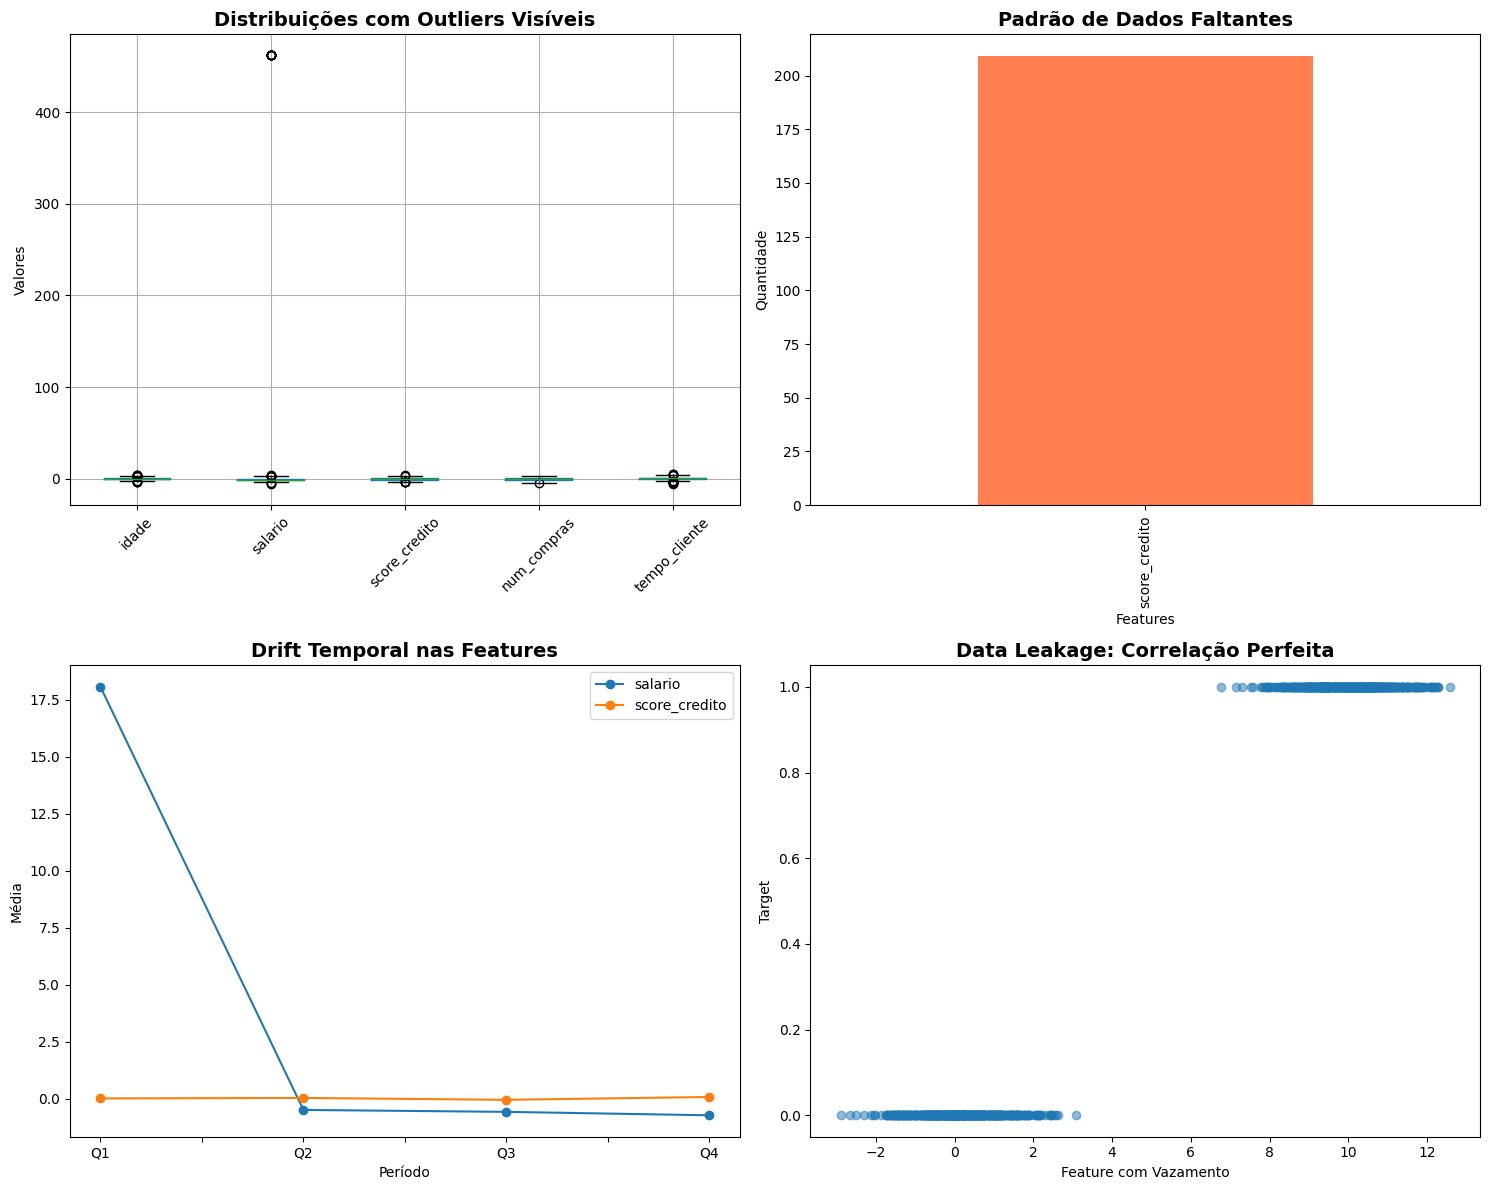


=== SOLUÇÃO: Tratamento Adequado dos Dados ===

1. ✅ Removendo feature com data leakage
2. ✅ Tratando outliers extremos (capping)
3. ✅ Imputação baseada em grupos (não apenas média geral)
4. ✅ Criando features que fazem sentido para o negócio
5. ✅ Usando validação temporal (não aleatória)

📊 Acurácia REAL (dados limpos, validação temporal): 90.50%
📊 Acurácia FALSA (com problemas): 100.00%

🎯 Diferença: 9.50% de overfitting/leakage!

=== LIÇÕES APRENDIDAS ===

1. 🧐 SEMPRE fazer EDA antes de modelar
2. 🚫 Dados faltantes raramente são aleatórios
3. 📈 Outliers podem ser erros OU informação valiosa
4. ⏰ Validação temporal > validação aleatória
5. 🔍 Procure por data leakage (correlações muito altas)
6. 📊 Features de negócio > features automáticas
7. 🎯 Métricas realistas > métricas inflacionadas

💡 CONCLUSÃO:
PyCaret e AutoML são ferramentas, não soluções mágicas.
O valor real está em ENTENDER seus dados e o problema de negócio.
Sem isso, você está apenas criando modelos inúteis com métricas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Criar um dataset com problemas realistas
np.random.seed(42)

# Gerar dados base
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, 
                          n_redundant=1, n_classes=2, random_state=42)

# Converter para DataFrame
feature_names = ['idade', 'salario', 'score_credito', 'num_compras', 'tempo_cliente']
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# INTRODUZIR PROBLEMAS REALISTAS NOS DADOS

# 1. Outliers extremos
df.loc[df.index[:10], 'salario'] = df['salario'].max() * 100  # CEOs?

# 2. Valores faltantes não aleatórios
# Pessoas com salário baixo tendem a não informar score de crédito
mask_low_salary = df['salario'] < df['salario'].quantile(0.3)
df.loc[mask_low_salary, 'score_credito'] = np.where(
    np.random.random(mask_low_salary.sum()) < 0.7, np.nan, df.loc[mask_low_salary, 'score_credito']
)

# 3. Vazamento de dados (data leakage)
# Criar uma feature que "vaza" informação do target
df['feature_vazamento'] = df['target'] * 10 + np.random.normal(0, 1, len(df))

# 4. Desequilíbrio temporal
# Simular que dados mais recentes têm padrão diferente
df['data_coleta'] = pd.date_range('2020-01-01', periods=len(df), freq='D')
df.loc[df.index[800:], feature_names] = df.loc[df.index[800:], feature_names] * 1.5

print("=== CENÁRIO: Aplicar ML Cegamente (Estilo PyCaret) ===\n")

# Abordagem ERRADA: Aplicar modelo direto
print("1. ABORDAGEM INGÊNUA - Jogar tudo no modelo:")
print("-" * 50)

# Separar features e target (incluindo a feature com vazamento!)
X_naive = df[feature_names + ['feature_vazamento']].fillna(0)  # Preenchimento ingênuo
y_naive = df['target']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_naive, y_naive, test_size=0.2, random_state=42)

# Treinar modelo
rf_naive = RandomForestClassifier(random_state=42)
rf_naive.fit(X_train, y_train)

# Avaliar
y_pred_naive = rf_naive.predict(X_test)
acc_naive = accuracy_score(y_test, y_pred_naive)

print(f"Acurácia (com todos os problemas): {acc_naive:.2%}")
print("Parece ótimo, certo? ERRADO! Vamos ver por quê...\n")

# Importância das features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_naive.feature_importances_
}).sort_values('importance', ascending=False)

print("Features mais importantes:")
print(feature_importance)
print("\n🚨 ALERTA: 'feature_vazamento' é a mais importante! Data leakage!\n")

print("=" * 70)
print("=== ABORDAGEM CORRETA: Entender os Dados Primeiro ===\n")

# 1. ANÁLISE EXPLORATÓRIA
print("1. ANÁLISE DE DADOS FALTANTES:")
print("-" * 50)
missing_analysis = pd.DataFrame({
    'coluna': df.columns,
    'valores_faltantes': df.isnull().sum(),
    'percentual': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_analysis[missing_analysis['valores_faltantes'] > 0])

# Analisar padrão de dados faltantes
print("\n📊 Análise: Score de crédito faltante por faixa salarial:")
salary_bins = pd.qcut(df['salario'], q=5, labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
missing_by_salary = df.groupby(salary_bins)['score_credito'].apply(lambda x: x.isnull().sum() / len(x) * 100)
print(missing_by_salary.round(2))
print("\n💡 Insight: Dados faltantes NÃO são aleatórios! Correlacionam com salário baixo.")

# 2. DETECÇÃO DE OUTLIERS
print("\n2. ANÁLISE DE OUTLIERS:")
print("-" * 50)

# Método IQR para detectar outliers
for col in feature_names:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    if len(outliers) > 0:
        print(f"\n{col}: {len(outliers)} outliers detectados")
        print(f"  Valores: {outliers[col].values[:5]}...")  # Mostrar alguns exemplos

# 3. ANÁLISE TEMPORAL
print("\n3. ANÁLISE DE DRIFT TEMPORAL:")
print("-" * 50)

# Comparar distribuições entre períodos
df['periodo'] = pd.cut(df.index, bins=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
drift_analysis = df.groupby('periodo')[feature_names].mean()
print("\nMédia das features por período:")
print(drift_analysis.round(2))
print("\n💡 Insight: Dados mudam significativamente no Q4! Possível drift.")

# 4. CORRELAÇÕES SUSPEITAS
print("\n4. ANÁLISE DE CORRELAÇÕES:")
print("-" * 50)

# Calcular correlações incluindo a feature suspeita
corr_matrix = df[feature_names + ['feature_vazamento', 'target']].corr()
print("\nCorrelações com o target:")
print(corr_matrix['target'].sort_values(ascending=False))
print("\n🚨 ALERTA: 'feature_vazamento' tem correlação perfeita com target!")

# VISUALIZAÇÕES
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição com outliers
ax1 = axes[0, 0]
df.boxplot(column=feature_names, ax=ax1, rot=45)
ax1.set_title('Distribuições com Outliers Visíveis', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valores')

# 2. Padrão de dados faltantes
ax2 = axes[0, 1]
missing_pattern = df.isnull().sum()[df.isnull().sum() > 0]
missing_pattern.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Padrão de Dados Faltantes', fontsize=14, fontweight='bold')
ax2.set_ylabel('Quantidade')
ax2.set_xlabel('Features')

# 3. Drift temporal
ax3 = axes[1, 0]
for col in ['salario', 'score_credito']:
    df.groupby('periodo')[col].mean().plot(ax=ax3, marker='o', label=col)
ax3.set_title('Drift Temporal nas Features', fontsize=14, fontweight='bold')
ax3.set_xlabel('Período')
ax3.set_ylabel('Média')
ax3.legend()

# 4. Correlação suspeita
ax4 = axes[1, 1]
ax4.scatter(df['feature_vazamento'], df['target'], alpha=0.5)
ax4.set_title('Data Leakage: Correlação Perfeita', fontsize=14, fontweight='bold')
ax4.set_xlabel('Feature com Vazamento')
ax4.set_ylabel('Target')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("=== SOLUÇÃO: Tratamento Adequado dos Dados ===\n")

# Criar cópia limpa dos dados
df_clean = df.copy()

# 1. Remover feature com vazamento
print("1. ✅ Removendo feature com data leakage")
df_clean = df_clean.drop('feature_vazamento', axis=1)

# 2. Tratar outliers
print("2. ✅ Tratando outliers extremos (capping)")
for col in feature_names:
    Q1 = df_clean[col].quantile(0.01)
    Q99 = df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lower=Q1, upper=Q99)

# 3. Imputação inteligente
print("3. ✅ Imputação baseada em grupos (não apenas média geral)")
# Imputar score_credito baseado na faixa salarial
salary_groups = pd.qcut(df_clean['salario'], q=5)
df_clean['score_credito'] = df_clean.groupby(salary_groups)['score_credito'].transform(
    lambda x: x.fillna(x.median())
)

# 4. Feature engineering
print("4. ✅ Criando features que fazem sentido para o negócio")
df_clean['ratio_compras_tempo'] = df_clean['num_compras'] / (df_clean['tempo_cliente'] + 1)
df_clean['score_normalizado'] = (df_clean['score_credito'] - df_clean['score_credito'].mean()) / df_clean['score_credito'].std()

# 5. Validação temporal
print("5. ✅ Usando validação temporal (não aleatória)")
# Treinar com dados antigos, testar com recentes
train_idx = df_clean.index[:800]
test_idx = df_clean.index[800:]

X_train_clean = df_clean.loc[train_idx, feature_names + ['ratio_compras_tempo', 'score_normalizado']]
y_train_clean = df_clean.loc[train_idx, 'target']
X_test_clean = df_clean.loc[test_idx, feature_names + ['ratio_compras_tempo', 'score_normalizado']]
y_test_clean = df_clean.loc[test_idx, 'target']

# Treinar modelo correto
rf_clean = RandomForestClassifier(random_state=42)
rf_clean.fit(X_train_clean, y_train_clean)

# Avaliar
y_pred_clean = rf_clean.predict(X_test_clean)
acc_clean = accuracy_score(y_test_clean, y_pred_clean)

print(f"\n📊 Acurácia REAL (dados limpos, validação temporal): {acc_clean:.2%}")
print(f"📊 Acurácia FALSA (com problemas): {acc_naive:.2%}")
print(f"\n🎯 Diferença: {(acc_naive - acc_clean):.2%} de overfitting/leakage!")

print("\n" + "=" * 70)
print("=== LIÇÕES APRENDIDAS ===\n")

lessons = [
    "1. 🧐 SEMPRE fazer EDA antes de modelar",
    "2. 🚫 Dados faltantes raramente são aleatórios",
    "3. 📈 Outliers podem ser erros OU informação valiosa",
    "4. ⏰ Validação temporal > validação aleatória",
    "5. 🔍 Procure por data leakage (correlações muito altas)",
    "6. 📊 Features de negócio > features automáticas",
    "7. 🎯 Métricas realistas > métricas inflacionadas"
]

for lesson in lessons:
    print(lesson)

print("\n💡 CONCLUSÃO:")
print("PyCaret e AutoML são ferramentas, não soluções mágicas.")
print("O valor real está em ENTENDER seus dados e o problema de negócio.")
print("Sem isso, você está apenas criando modelos inúteis com métricas falsas.")

# Bônus: Mostrar importância das features reais
print("\n📊 Features importantes (modelo correto):")
feature_importance_clean = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': rf_clean.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_clean.head())
print("\nAgora sim, features que fazem sentido para o negócio!")